In [1]:
# Librerias basicas 
import numpy as np 
import pandas as pd 
import os

# Visualizacióon
import matplotlib.pyplot as plt
import seaborn as sns 
from plotly import express as px

# Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, accuracy_score, mean_absolute_error, r2_score, classification_report # Metricas
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Guardar modelos
import pickle

# Models
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# WoE
from category_encoders import *

# Preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Clasificación

In [156]:
df = pd.read_csv('./csv/clasificacion-personas.csv')

### Análisis exploratorio de datos

In [95]:
df.shape

(27656, 16)

In [96]:
df.head(1)

,index,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ID
0,24466,30,Local-gov,HS-grad,9,Divorced,Protective-serv,Own-child,White,Female,0,0,32,United-States,<=50K,24451


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27656 entries, 0 to 27655
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   index           27656 non-null  int64 
 1   age             27656 non-null  int64 
 2   workclass       27656 non-null  object
 3   education       27656 non-null  object
 4   education.num   27656 non-null  int64 
 5   marital.status  27656 non-null  object
 6   occupation      27656 non-null  object
 7   relationship    27656 non-null  object
 8   race            27656 non-null  object
 9   sex             27656 non-null  object
 10  capital.gain    27656 non-null  int64 
 11  capital.loss    27656 non-null  int64 
 12  hours.per.week  27656 non-null  int64 
 13  native.country  27656 non-null  object
 14  income          27656 non-null  object
 15  ID              27656 non-null  int64 
dtypes: int64(7), object(9)
memory usage: 3.4+ MB


In [98]:
df.isna().sum()

index             0
age               0
workclass         0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
ID                0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
index,27656.0,16274.894851,9410.041750,0.0,8104.75,16296.0,24431.25,32559.0
age,27656.0,38.610356,13.659928,17.0,28.00,37.0,48.00,90.0
education.num,27656.0,10.093506,2.566083,1.0,9.00,10.0,12.00,16.0
capital.gain,27656.0,1099.991503,7487.323462,0.0,0.00,0.0,0.00,99999.0
capital.loss,27656.0,88.284387,405.821328,0.0,0.00,0.0,0.00,4356.0
hours.per.week,27656.0,40.446666,12.369212,1.0,40.00,40.0,45.00,99.0
ID,27656.0,16267.565736,9403.092602,0.0,8104.75,16291.0,24416.25,32535.0


In [ ]:
df.head(1)

,index,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ID
0,24466,30,Local-gov,HS-grad,9,Divorced,Protective-serv,Own-child,White,Female,0,0,32,United-States,<=50K,24451


Matriz de correlación

c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

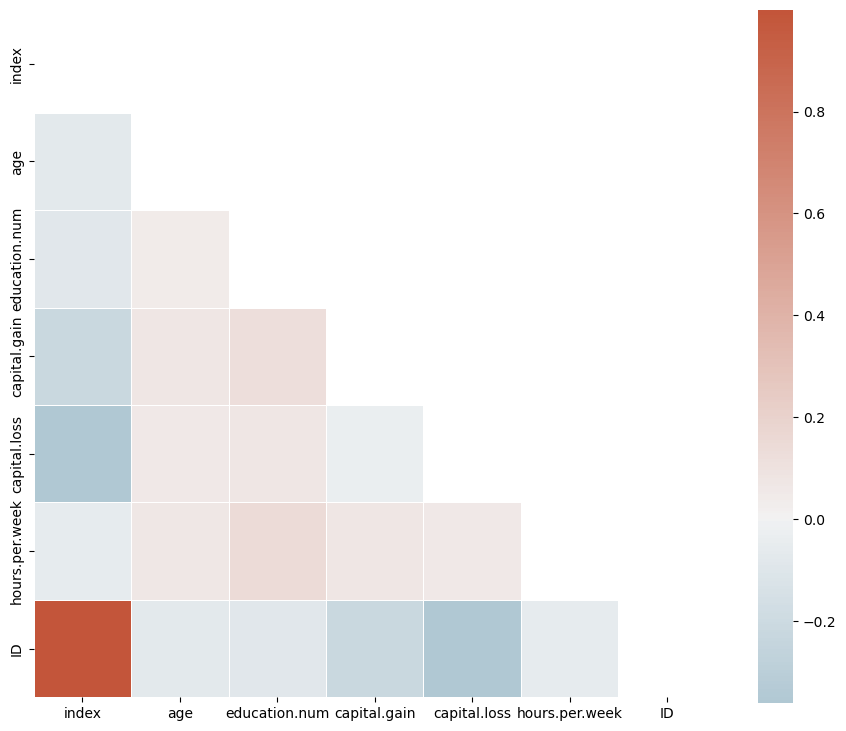

In [99]:
# Identificar columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df[numeric_cols].corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df[numeric_cols].corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True)

Distribución de la variable target _income_

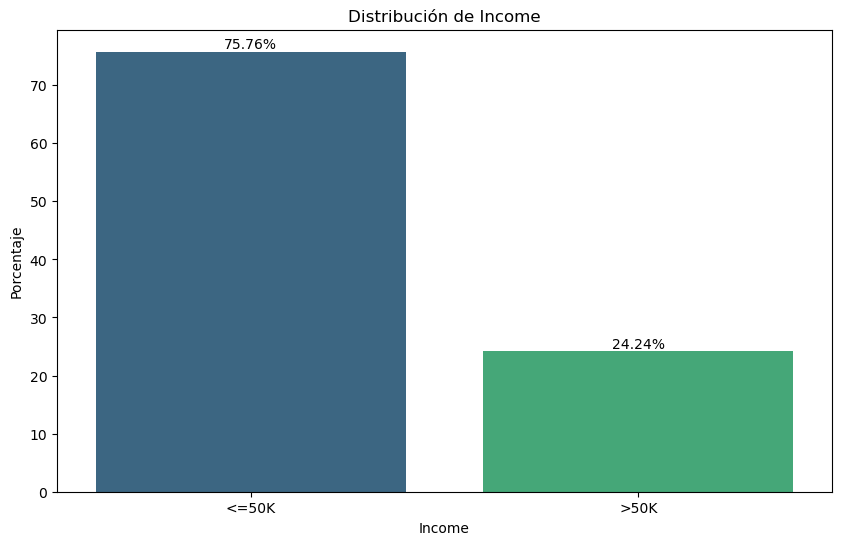

In [ ]:
# Calcular los porcentajes
income_counts = df['income'].value_counts()
income_percentages = income_counts / income_counts.sum() * 100

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=income_percentages.index, y=income_percentages.values, palette='viridis')

# Añadir los porcentajes en la parte superior de las barras
for index, value in enumerate(income_percentages.values):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')

# Personalizar el gráfico
plt.title('Distribución de Income')
plt.xlabel('Income')
plt.ylabel('Porcentaje')

plt.show()

In [ ]:
df.income.value_counts()

income
<=50K    20953
>50K      6703
Name: count, dtype: int64

### Preprocesamiento y Feature Engineering

Convertimos variable categorica a entero


In [157]:
map_income = {'<=50K':0,
            '>50K':1}

df['income'] = df['income'].replace(map_income)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5748\1062044960.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['income'] = df['income'].replace(map_income)


Eliminamos variables que no nos interesan

In [158]:
df.drop(['index'], inplace=True, axis=1)
df.drop(['ID'], inplace=True, axis=1)

Pipeline: Imputar, estandarizar y transformar

In [159]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['income']]
columns_to_keep = ['age', 'capital.gain', 'capital.loss', 'hours.per.week']
numeric_features_to_scale = [col for col in numeric_features if col in columns_to_keep]

In [160]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [163]:
categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('column_transformer', ColumnTransformer(
        #[('scaler', StandardScaler(), [0,2,3,4])],
        [('scaler', StandardScaler())],
        remainder='passthrough'
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numericas', numeric_pipe, numeric_features),
        ('categoricas', categorical_pipe, categorical_features)
        ],
        remainder='passthrough'  # para no perder las columnas que no son escaladas
    )

In [179]:
# Pipeline para imputar todas las columnas numéricas
numeric_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Pipeline para escalar solo las columnas numéricas especificadas
numeric_scaler = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Pipeline para columnas categóricas (si las tienes)
categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar todo en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num_imputer', numeric_imputer, numeric_features),
        ('num_scaler', numeric_scaler, numeric_features),
        ('cat', categorical_pipe, categorical_features)  # Si tienes características categóricas
    ])

### Train Test

In [164]:
SEED = 12345
TEST_SIZE = 0.2

In [165]:
# Suponiendo que tienes un DataFrame df_regresion y quieres predecir la variable 'Price'
X = df.drop(columns=['income'])  # Variables predictoras
y = df['income']  # Variable objetivo

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [139]:
conjuntos = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
for key, value in conjuntos.items():
    print(f"{key}: {len(value)} filas")

X_train: 22124 filas
X_test: 5532 filas
y_train: 22124 filas
y_test: 5532 filas


### Modelos

Modelos a utilizar

In [ ]:
classification_models = {
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'MLP': MLPClassifier()
}

Hiperparámetros de los modelos

In [15]:
classification_param_grids = {
    'SVM': {
        'model__C': [0.1, 1, 10],
        'model__kernel': ['rbf', 'linear']
    },
    'Random Forest': {
        'model__n_estimators': [50, 100],
        'model__max_depth': [None, 10, 20]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100],
        'model__learning_rate': [0.01, 0.1]
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,)],
        'model__alpha': [0.0001, 0.001]
    }
}

Función para entrenar modelos

In [192]:
def train_model(X, y, models, param_grids, cv=5, scoring='accuracy'):
    results = []
    for name, model in models.items():
        pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                     ("model", model)])
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv, scoring=scoring, n_jobs=-1)
        grid_search.fit(X, y)
        results.append({
            'Model': name,
            'Best Score': grid_search.best_score_,
            'Best Params': grid_search.best_params_
            #'best_model' : grid_search.best_estimator_
        })
       
        # Guardar resultados en archivo CSV
        results_df = pd.DataFrame(results)
        results_df.to_csv('f"{name}_classifier.csv', index=False, sep=';')
       
        # Guardar el mejor modelo
        pkl_Filename = f"{name}_classifier.pkl"  
        with open(pkl_Filename, 'wb') as file:
            pickle.dump(grid_search.best_estimator_, file)

    return pd.DataFrame(results)

Entrenamos los modelos

In [193]:
print("Resultados de Clasificación:")
results = train_model(X_train, y_train, classification_models, classification_param_grids)
print(results)

Resultados de Clasificación:


Función para levantar los modelos entrenados

In [31]:
def pickle_load(name_model):   
    with open( f"{name_model}.pkl", 'rb') as file:
        pickle_model = pickle.load(file)
    return pickle_model

Levantamos los modelos

In [88]:
SVM = pickle_load('SVM_classifier')
RandomForest = pickle_load('Random Forest_classifier')
GradientBoosting = pickle_load('Gradient Boosting_classifier')
MLP = pickle_load('MLP_classifier')

Función para realizar predicciones

In [91]:
def test_model(X_test):

    predictions_df = pd.DataFrame()
    predictions_df['SVM'] = SVM.predict(X_test) 
    predictions_df['RandomForest'] = RandomForest.predict(X_test)
    predictions_df['GradientBoosting'] = GradientBoosting.predict(X_test)
    predictions_df['MLP'] = MLP.predict(X_test)

    return predictions_df

Función para generar matriz de confusión

In [99]:
def confusionMatrix(y_test, y_pred):
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
    cm_display.plot()
    plt.show()

Predicciones

In [92]:
predicciones = test_model(X_test)

#### Métricas del SVC

Accuracy

In [94]:
print(classification_report(y_test,  predicciones['SVM']))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88      4191
           1       0.71      0.24      0.35      1341

    accuracy                           0.79      5532
   macro avg       0.76      0.60      0.61      5532
weighted avg       0.78      0.79      0.75      5532



Matriz de confusión

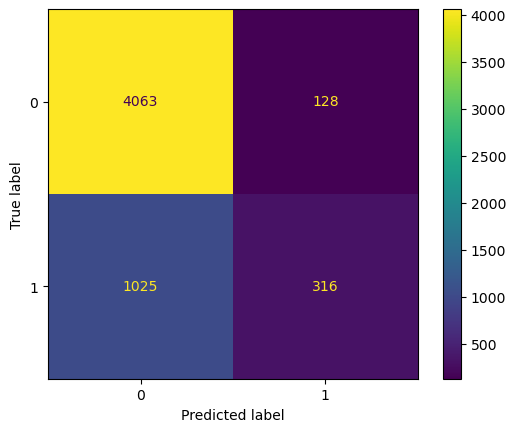

In [100]:
confusionMatrix(y_test,  predicciones['SVM'])

### Grafico de la curva roc

In [ ]:
#De esta forma graficamos la curva ROC y calculamos el área debajo de la curva
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve

plt.title("Grafico ROC para el model")


areaBajoCurva = roc_auc_score(y_test, predicciones['SVM'])
fpr, tpr, _ = roc_curve(y_test, predicciones['SVM'])
plt.plot(fpr, tpr, label="{} - AUC:{}".format('SVC', round(areaBajoCurva,4)))


areaBajoCurva = roc_auc_score(y_test, predicciones['RandomForest'])
fpr, tpr, _ = roc_curve(y_test, predicciones['RandomForest'])
plt.plot(fpr, tpr, label="{} - AUC:{}".format('RandomForest', round(areaBajoCurva,4)))

areaBajoCurva = roc_auc_score(y_test, predicciones['GradientBoosting'])
fpr, tpr, _ = roc_curve(y_test, predicciones['GradientBoosting'])
plt.plot(fpr, tpr, label="{} - AUC:{}".format('GradientBoosting', round(areaBajoCurva,4)))

areaBajoCurva = roc_auc_score(y_test, predicciones['MLP'])
fpr, tpr, _ = roc_curve(y_test, predicciones['MLP'])
plt.plot(fpr, tpr, label="{} - AUC:{}".format('MLP', round(areaBajoCurva,4)))

plt.legend(loc="lower right")
plt.plot([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Regresión

In [55]:
df = pd.read_csv('./csv/car-prices.csv')

### Análisis exploratorio de datos

In [60]:
df.shape

(4345, 9)

In [57]:
df.head(1)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         4345 non-null   object 
 1   Price         4173 non-null   float64
 2   Body          4345 non-null   object 
 3   Mileage       4345 non-null   int64  
 4   EngineV       4195 non-null   float64
 5   Engine Type   4345 non-null   object 
 6   Registration  4345 non-null   object 
 7   Year          4345 non-null   int64  
 8   Model         4345 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.6+ KB


In [59]:
df.isna().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

In [61]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,4173.0,19418.746935,25584.242620,600.0,6999.0,11500.0,21700.0,300000.00
Mileage,4345.0,161.237284,105.705797,0.0,86.0,155.0,230.0,980.00
EngineV,4195.0,2.790734,5.066437,0.6,1.8,2.2,3.0,99.99
Year,4345.0,2006.550058,6.719097,1969.0,2003.0,2008.0,2012.0,2016.00


Matríz de correlación

<Axes: >

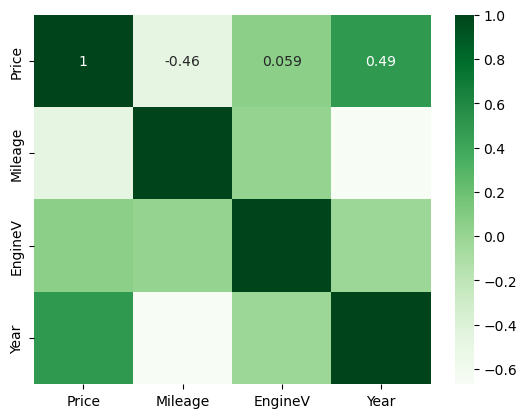

In [62]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
matrix = df[numeric_cols].corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

Price es nuestro target, ¿cómo se distribuye?

c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Count'>

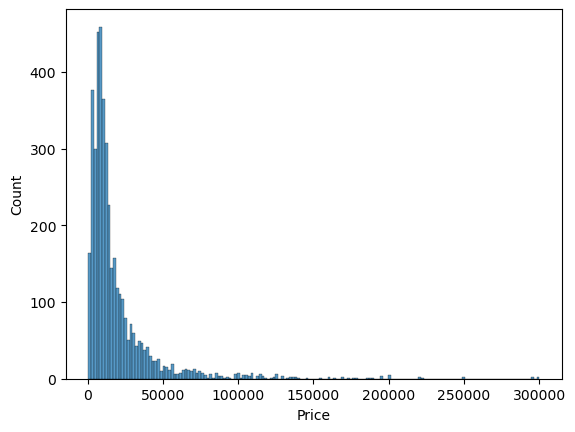

In [63]:
sns.histplot(x= 'Price', data=df)

Boxplot: Variables categóricas vs Price

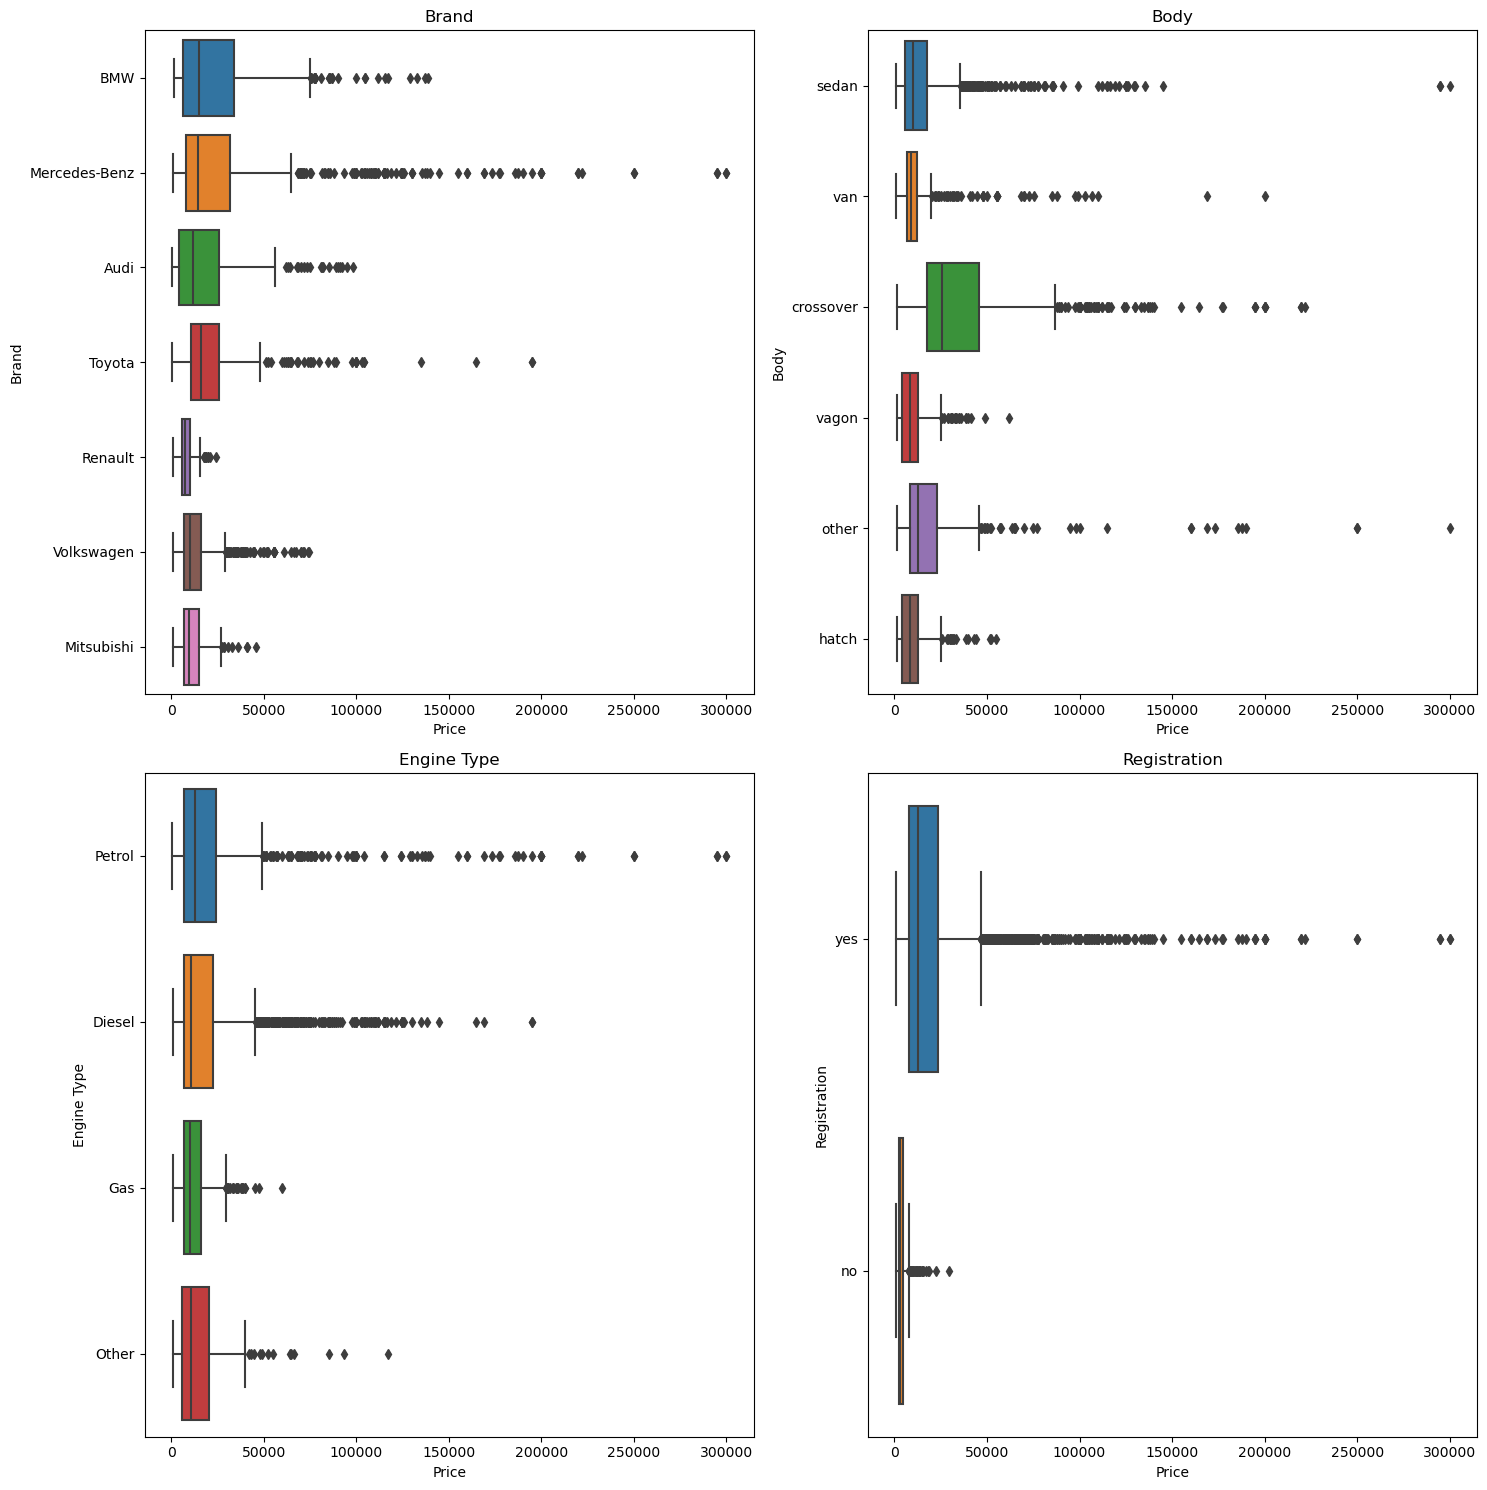

In [71]:
categorical_features = ['Brand', 'Body', 'Engine Type', 'Registration']
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()
for i, col in enumerate(categorical_features):
    sns.boxplot(data=df,
                x="Price", y=col,
                ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

Variables continuas vs Price

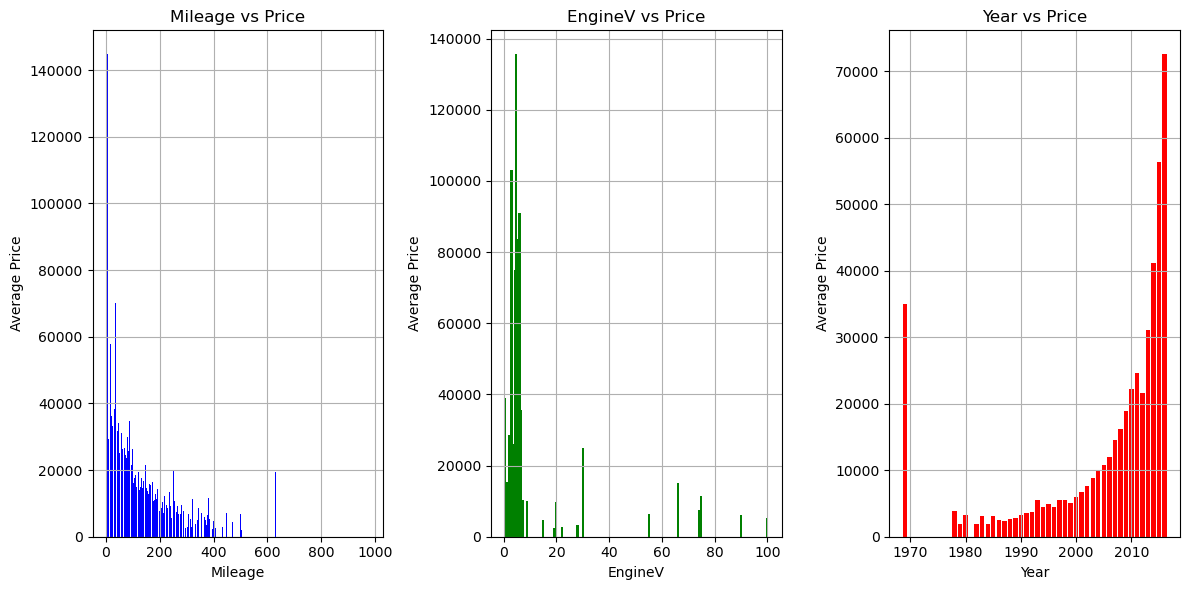

In [72]:
# Calcular el promedio de Price para cada valor único de Mileage, EngineV y Year
avg_price_mileage = df.groupby('Mileage')['Price'].mean()
avg_price_enginev = df.groupby('EngineV')['Price'].mean()
avg_price_year = df.groupby('Year')['Price'].mean()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))

# Gráfico de barras para Mileage vs Price
plt.subplot(1, 3, 1)
plt.bar(avg_price_mileage.index, avg_price_mileage.values, color='blue')
plt.title('Mileage vs Price')
plt.xlabel('Mileage')
plt.ylabel('Average Price')
plt.grid(True)

# Gráfico de barras para EngineV vs Price
plt.subplot(1, 3, 2)
plt.bar(avg_price_enginev.index, avg_price_enginev.values, color='green')
plt.title('EngineV vs Price')
plt.xlabel('EngineV')
plt.ylabel('Average Price')
plt.grid(True)

# Gráfico de barras para Year vs Price
plt.subplot(1, 3, 3)
plt.bar(avg_price_year.index, avg_price_year.values, color='red')
plt.title('Year vs Price')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid(True)

# Ajustar automáticamente la distribución de los subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Rango de _Years_

In [29]:
print(f"Desde {df.Year.min()} hasta {df.Year.max()}")

1969

### Preprocesamiento y Feature Engineering

Imputamos Price

In [73]:
# Imputación de valores faltantes con la mediana
median_price = df['Price'].median()
df['Price'].fillna(median_price, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5748\3545065822.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].fillna(median_price, inplace=True)



Vamos a descartar la variable Model por simplicidad

In [74]:
df.drop(['Model'], inplace=True, axis=1)

Creacion de pipelines de transformacion: SimpleImputer, OneHotEncoding y StandarScaler

In [75]:
numeric_features = [col for col in numeric_features if col not in ['Price']]
columns_to_keep = ['Mileage', 'EngineV']
numeric_features_to_scale = [col for col in numeric_features if col in columns_to_keep]

In [76]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [79]:
categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('column_transformer', ColumnTransformer(
        [('scaler', StandardScaler(), [0,1])],
        remainder='passthrough'
    ))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numericas', numeric_pipe, numeric_features),
        ('categoricas', categorical_pipe, categorical_features)
        ],
        remainder='passthrough'  # para no perder las columnas que no son escaladas
    )

### Train y Test

In [80]:
SEED = 12345
TEST_SIZE = 0.2

In [81]:
# Suponiendo que tienes un DataFrame df_regresion y quieres predecir la variable 'Price'
X = df.drop(columns=['Price'])  # Variables predictoras
y = df['Price']  # Variable objetivo

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [82]:
conjuntos = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
for key, value in conjuntos.items():
    print(f"{key}: {len(value)} filas")

X_train: 3476 filas
X_test: 869 filas
y_train: 3476 filas
y_test: 869 filas


### Modelos

In [83]:
regression_models = {
    'SVM': SVR(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'MLP': MLPRegressor()
}

In [84]:
regression_param_grids = {
    'SVM': {
        'model__C': [0.1, 1, 10], 
        'model__kernel': ['rbf', 'linear']
    },
    'Random Forest': {
        'model__n_estimators': [50, 100], 
        'model__max_depth': [None, 10, 20]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100], 
        'model__learning_rate': [0.01, 0.1]
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,)], 
        'model__alpha': [0.0001, 0.001]
    }
}


In [85]:
# Función para evaluar y comparar modelos
def train_models(X, y, models, param_grids, cv=5, scoring='neg_mean_squared_error'):
    results = []
    for name, model in models.items():
        pipeline = Pipeline(steps=[("model", model)])
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv, scoring=scoring, n_jobs=-1)
        grid_search.fit(X, y)
        results.append({
            'Model': name,
            'Best Score': grid_search.best_score_,
            'Best Params': grid_search.best_params_
        })
       
        # Guardamos los resultados
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'./metrics/{name}_regressor.csv', index=False, sep=';')
       
        # Guardar el mejor modelo
        pkl_Filename = f"./models/{name}_regressor.pkl"  
        with open(pkl_Filename, 'wb') as file:
            pickle.dump(grid_search.best_estimator_, file)
    
    return pd.DataFrame(results)

In [86]:
print("Resultados de Clasificación:")
results = train_models(X_train, y_train, regression_models, regression_param_grids)
print(results)

Resultados de Clasificación:
  Model    Best Score                                  Best Params
0   SVM -5.090318e+08  {'model__C': 10, 'model__kernel': 'linear'}


In [87]:
SVM = pickle_load('SVM_regressor')
RandomForest = pickle_load('Random Forest_regressor')
GradientBoosting = pickle_load('Gradient Boosting_regressor')
MLP = pickle_load('SVM_regressor')

In [88]:
def test_model(X_test):
    predictions_df = pd.DataFrame()
    predictions_df['SVM'] = SVM.predict(X_test) 
    predictions_df['RandomForest'] = RandomForest.predict(X_test)
    predictions_df['GradientBoosting'] = GradientBoosting.predict(X_test)
    predictions_df['MLP'] = MLP.predict(X_test)
    
    return predictions_df

In [89]:
predicciones = test_model(X_test)

SVR

In [90]:
mse = mean_squared_error(y_test, predicciones['SVM'])
r2 = r2_score(y_test, predicciones['SVM'])
mae = mean_absolute_error(y_test, predicciones['SVM'])

print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')

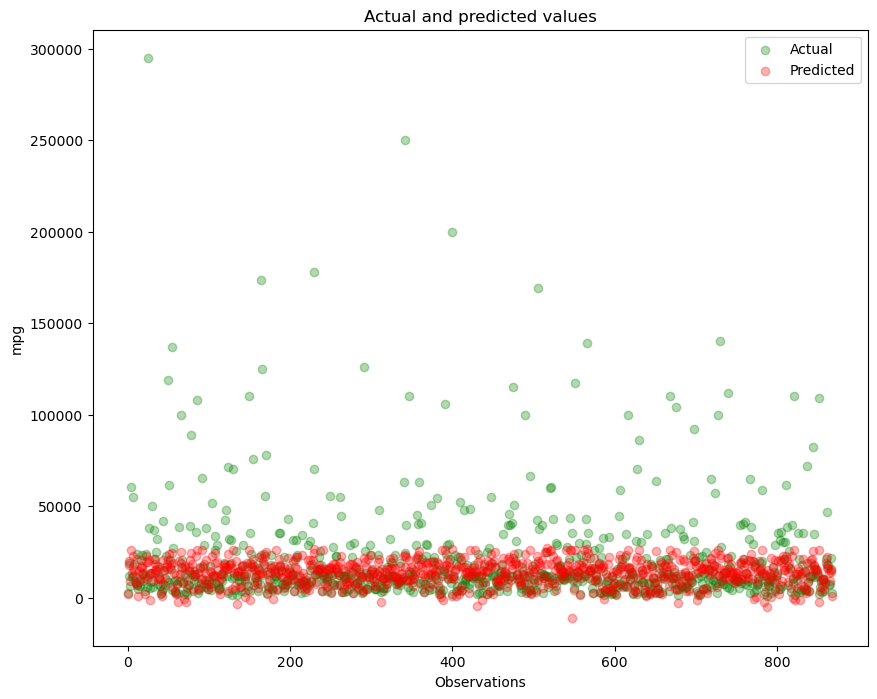

In [91]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'green', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0,  predicciones['SVM'].size), y=predicciones['SVM'], c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

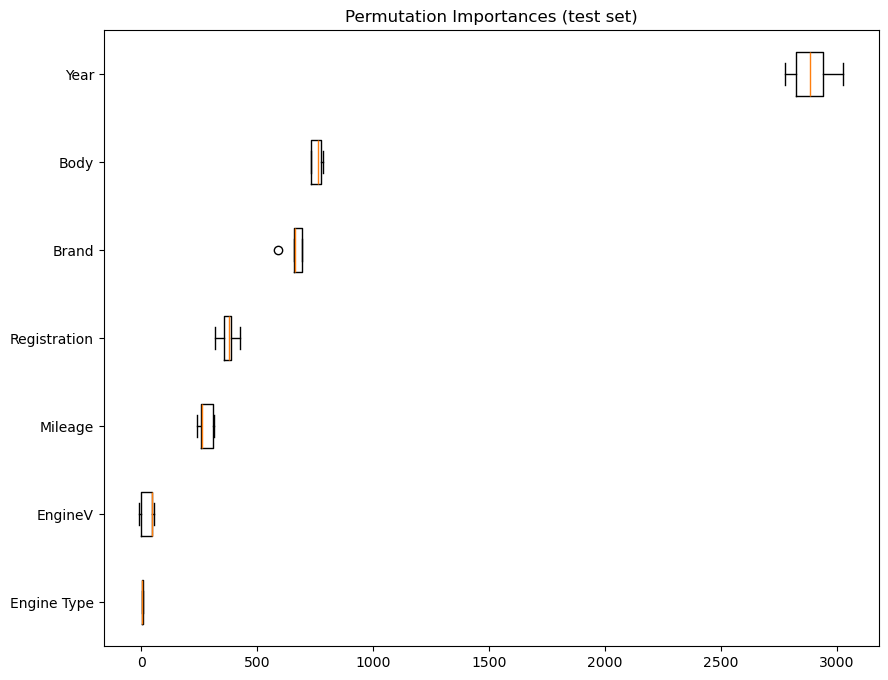

In [92]:
imps = permutation_importance(SVM, X_test, y_test,
                              n_repeats = 5,
                              scoring= "neg_mean_absolute_error",
                              n_jobs=-1, random_state=42)
fig= plt.figure(figsize=(10,8))
perm_sorted_idx = imps.importances_mean.argsort()
plt.boxplot(imps.importances[perm_sorted_idx].T, vert=False,
            labels=X_test.columns[perm_sorted_idx])
plt.title("Permutation Importances (test set)");